In [1]:
MODEL_ID = "meta-llama/Llama-3.2-1B-Instruct"

In [15]:
history_path = '../outputs/xgrammar/history_statistics_yHMH.json'
all_history_path = '../outputs/xgrammar/yHMH.jsonl'
history_folder = '../outputs/xgrammar'

In [3]:
def color_print(output_token_ids, decoding_history, tokenizer):
    RED = "\033[31m"
    BLUE = "\033[34m"
    RESET = "\033[0m"

    colored_output = ""
    for i, token_id in enumerate(output_token_ids):
        if i < len(decoding_history):
            step_info = decoding_history[i][0]
            is_intervened = step_info['metrics'].get('is_intervened', False)
        else:
            is_intervened = False
        token_str = tokenizer.decode([token_id])
        if is_intervened:
            colored_output += f"{RED}{token_str}{RESET}"
        else:
            colored_output += f"{BLUE}{token_str}{RESET}"
    return colored_output

# Intervention Rate Distribution

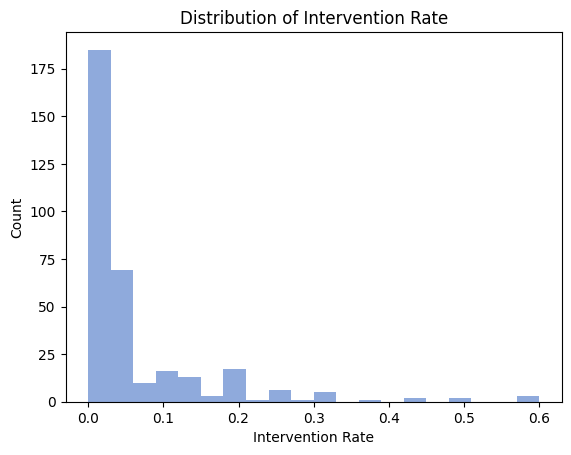

In [4]:
import json
import matplotlib.pyplot as plt

with open(history_path) as f:
    stats = json.load(f)

intervention_rates = [x['intervention_rate'] for x in stats]
plt.hist(intervention_rates, bins=20, color='#8FAADC')
plt.xlabel('Intervention Rate')
plt.ylabel('Count')
plt.title('Distribution of Intervention Rate')
plt.show()

# Intervention Rate vs. Mean Accepted Ratio

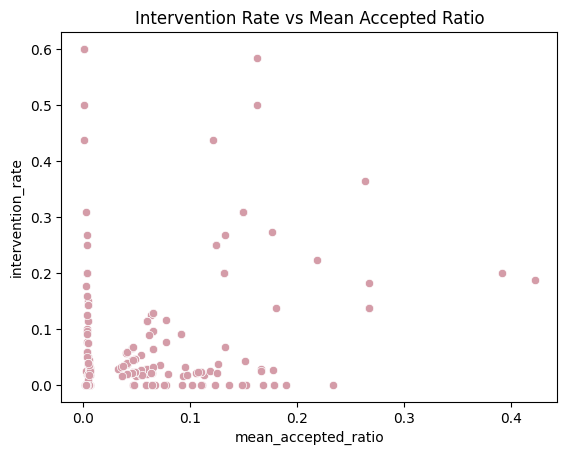

In [6]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(stats)
sns.scatterplot(x='mean_accepted_ratio', y='intervention_rate', data=df, color='#D49CA8')
plt.title('Intervention Rate vs Mean Accepted Ratio')
plt.show()

# Most Invtervened Samples

In [18]:
import json
import numpy as np
from transformers import AutoTokenizer

# Read the file and analyze interventions
samples = []

with open(all_history_path, 'r', encoding='utf-8') as f:
    for line_num, line in enumerate(f, 1):
        line = line.strip()
        if not line:
            continue
        record = json.loads(line)
        if "decoding_history" in record and len(record["decoding_history"]) > 0:
            # Count interventions
            interventions = 0
            for steps in record["decoding_history"]:
                step = steps[0]
                if isinstance(step, dict) and "metrics" in step:
                    if step["metrics"].get("is_intervened", False):
                        interventions += 1
            
            samples.append({
                "id": record.get("id", "unknown"),
                "schema": record.get("schema", "unknown"),
                "generation": record.get("generation", "unknown"),
                "interventions": interventions,
                "decoding_history": record["decoding_history"],
                "intervention_rate": interventions / len(record["decoding_history"]) if record["decoding_history"] else 0
            })

In [19]:
# Sort by interventions and show top 10
top_samples = sorted(samples, key=lambda x: x["interventions"], reverse=True)[:10]

print("Top 10 most intervened samples:")
print("-" * 50)
for i, sample in enumerate(top_samples, 1):
    print(f"{i}. ID: {sample['id']}")
    print(f"Interventions: {sample['interventions']}")
    
    output_str = sample['generation']
    decoding_history = sample['decoding_history']
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
    output_token_ids = tokenizer.encode(output_str, add_special_tokens=False)
    colored_output = color_print(output_token_ids, decoding_history, tokenizer)
    print(f'colored output: {colored_output}')
    
    print()

Top 10 most intervened samples:
--------------------------------------------------
1. ID: bb781a7a-b423-4790-9db1-e75fef21e107
Interventions: 7
colored output: {"dimensions": {"shape": "circle"}, "shape": "circle"}

2. ID: 1015999b-06e6-4311-bf7d-5420eab38d1d
Interventions: 7
colored output: {"shape": "circle" 
 		}

3. ID: 55464430-7471-4a26-b879-dd843a3e22f9
Interventions: 7
colored output: {"dimensions": {"shape": "circle"}, "shape": "circle"}

4. ID: 981264b3-5bdc-44d8-b669-82e435cdf219
Interventions: 6
colored output: {"dimensions": {"base": 10, "height": 20, "length": 30, "radius": 15, "width": 25}, "shape": "rectangle"}

5. ID: 1a3661ea-02a1-491b-bade-6ec6ed258c6d
Interventions: 6
colored output: {"shape": "circle" 	}

6. ID: 1eaaae5b-800c-4dd0-870e-308ceb0ca8b5
Interventions: 6
colored output: {"shape": "circle" 	}

7. ID: ebf5c53f-7167-401c-8f1f-a38ccad9dc29
Interventions: 6
colored output: {"shape": "rectangle" 
 		}

8. ID: 986d88cd-8ad3-4996-be60-bb03dac62c73
Interventions:

# Intervention Token Position

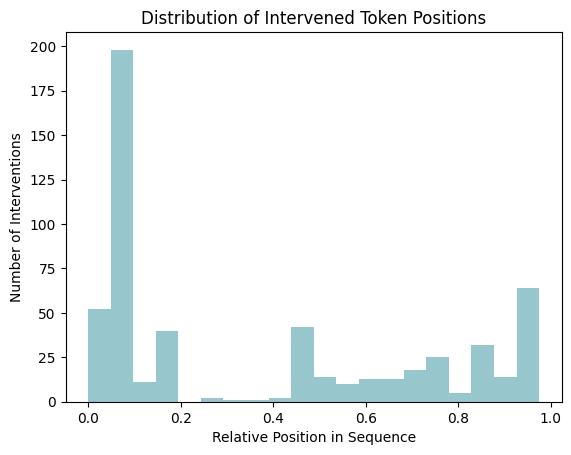

In [ ]:
import os
import json
import matplotlib.pyplot as plt

relative_positions = []

for sample in samples:
    decoding_history = sample['decoding_history']
    total_steps = len(decoding_history)
    for step, step_info in enumerate(decoding_history):
        metrics = step_info[0]['metrics']
        if metrics.get('is_intervened', False):
            rel_pos = step / total_steps
            relative_positions.append(rel_pos)

# 画直方图
plt.hist(relative_positions, bins=20, color='#6BAFB9', alpha=0.7)
plt.xlabel('Relative Position in Sequence')
plt.ylabel('Number of Interventions')
plt.title('Distribution of Intervened Token Positions')
plt.show()

# Intervention Token Types

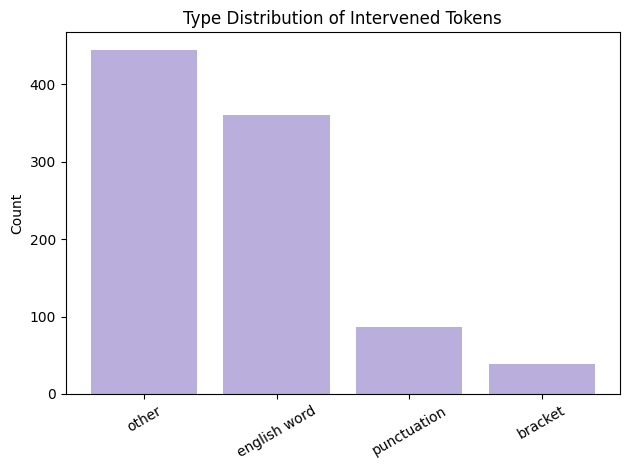

Top 20 intervened tokens and their counts:
'shape': 198
'Ä': 167
'Ĭ': 167
',': 73
'Äł': 63
'radius': 49
'}': 39
'",': 21
'null': 16
'Here': 14
'"}': 14
'base': 14
'"': 13
'length': 11
'location': 7
',"': 6
'or': 5
'min': 5
'start': 5
'loan': 4
Top 20 'other' tokens and their counts:
'Ä': 167
'Ĭ': 167
'Äł': 63
'",': 21
'"}': 14
',"': 6
'//': 4
'_title': 1
'#': 1
'```': 1


In [22]:
import os
import json
import re
from collections import Counter
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

def classify_token(token):
    if token.strip() == "":
        return "blank/newline"
    elif re.fullmatch(r"[.,:;!?\"'`]", token):
        return "punctuation"
    elif re.fullmatch(r"\d+", token):
        return "number"
    elif re.fullmatch(r"[a-zA-Z]+", token):
        return "english word"
    elif re.fullmatch(r"<\|.*\|>", token):
        return "special token"
    elif re.fullmatch(r"[\{\}\[\]\(\)]", token):
        return "bracket"
    elif re.fullmatch(r"\\n|\\t|\\r", token):
        return "escape character"
    else:
        return "other"

token_type_counter = Counter()

intervened_tokens = []
other_tokens = []

for sample in samples:
    decoding_history = sample['decoding_history']
    for step_info in decoding_history:
        metrics = step_info[0]['metrics']
        if metrics.get('is_intervened', False):
            token = metrics.get('top_token', None)
            if token is not None:
                # tokenizer may decode out multiple characters, count each one
                for t in tokenizer.tokenize(token):
                    token_type_counter[classify_token(t)] += 1
                    intervened_tokens.append(t)
                    if classify_token(t) == "other":
                        other_tokens.append(t)
                        
# visualize
labels, values = zip(*token_type_counter.most_common())
plt.bar(labels, values, color='#B9AEDC')
plt.ylabel('Count')
plt.title('Type Distribution of Intervened Tokens')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# most common tokens
from collections import Counter
intervened_counter = Counter(intervened_tokens)
print("Top 20 intervened tokens and their counts:")
for tok, cnt in intervened_counter.most_common(20):
    print(f"'{tok}': {cnt}")
    
from collections import Counter
other_counter = Counter(other_tokens)
print("Top 20 'other' tokens and their counts:")
for tok, cnt in other_counter.most_common(20):
    print(f"'{tok}': {cnt}")
